In [1]:
import utils
import models
import executor
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
import pandas as pd
from utils import perfect_square_acc
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# load your data here. The following ensure this will work on Windows as well as Unix
# the data file has its Kodaira symbols already preprocessed 
path = Path("..") / "data_files" / "sha"/ "ecq_sha_B_100_conds_1_500000_kodaira_processed.parquet"
df = utils.load_data(path)

# dropping columns that are not needed
df.drop(['conductor','adelic_level'], axis=1, inplace=True)

# process kodaira symbol if it is not already done
# path = Path("..") / "data_files" / "sha"/ "ecq_sha_B_100_conds_1_500000.parquet"
# df = utils.load_data(path)
# df = utils.process_kodaira_symbol(df)
# df.drop('lmfdb_label', axis=1, inplace=True)
# df.to_parquet(Path("..") / "data_files" / "sha"/ "ecq_sha_B_100_conds_1_500000_kodaira_processed.parquet")

Loaded the dataset with 118 features and 3064705 curves..


In [3]:
# to get a balanced dataset with equal amount of 1 and 4 labels
len_4 = df[df['sha'] == 4].shape[0]
df_balanced = df[df['sha'] == 1].sample(len_4) 
# df_balanced = df[df['sha'] == 1].iloc[:len_4]
df_balanced = pd.concat([df_balanced, df[df['sha'] == 4]])
df_balanced.sha.value_counts()

1    158758
4    158758
Name: sha, dtype: int64

In [9]:
# choose model parameters
hidden_units = [128,64,32]

# default model parameters
input_dim, output_dim = utils.get_input_output_dim(df_balanced, 'sha', if_regression=True)

# check if we have cuda available
device = utils.get_device()

# create model
model = models.VanillaNN(input_dim, hidden_units, output_dim, if_dropout=False, dropout_rate=0.5, if_batchnorm=True).to(device)

# print model summary
utils.model_summary(model)

The input dimension is 116 and the output dimension is 1.
Device: cpu.
The model has 25,793 trainable parameters..
VanillaNN(
  (layers): ModuleList(
    (0): Linear(in_features=116, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [10]:
# choose training parameters
loss_func = nn.MSELoss()
num_epochs = 30
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
evaluator = perfect_square_acc

Epoch 1/30. Training MSELoss : 0.4442, Validation MSELoss : 0.4543. Training perfect_square_acc: 0.9007, Validation perfect_square_acc: 0.9013
Epoch 2/30. Training MSELoss : 0.4346, Validation MSELoss : 0.4366. Training perfect_square_acc: 0.8755, Validation perfect_square_acc: 0.8773
Epoch 3/30. Training MSELoss : 0.3495, Validation MSELoss : 0.3597. Training perfect_square_acc: 0.9288, Validation perfect_square_acc: 0.9295
Epoch 4/30. Training MSELoss : 0.3249, Validation MSELoss : 0.3318. Training perfect_square_acc: 0.9316, Validation perfect_square_acc: 0.9324
Epoch 5/30. Training MSELoss : 0.3644, Validation MSELoss : 0.3728. Training perfect_square_acc: 0.9328, Validation perfect_square_acc: 0.9326
Epoch 6/30. Training MSELoss : 0.3133, Validation MSELoss : 0.3251. Training perfect_square_acc: 0.9402, Validation perfect_square_acc: 0.9392
Epoch 7/30. Training MSELoss : 0.2915, Validation MSELoss : 0.3014. Training perfect_square_acc: 0.9326, Validation perfect_square_acc: 0.9328

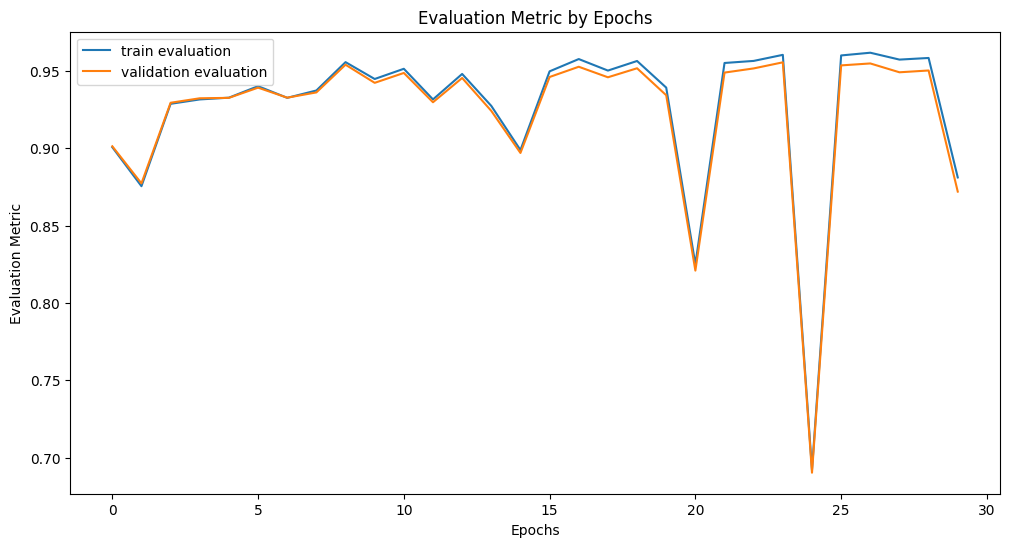

In [11]:
# split data
train_dataloader, val_dataset, test_dataset = utils.prepare_data(df_balanced, 'sha', device, if_regression=True)
# train the model
model, train_eval_hist, val_eval_hist, train_loss_hist, val_loss_hist = executor.train(model, train_dataloader, val_dataset, loss_func, evaluator, optimizer, num_epochs, if_regression=True, verbose=True)
# plot train_eval_hist, val_eval_hist
utils.plot_train_eval_hist(train_eval_hist, val_eval_hist)

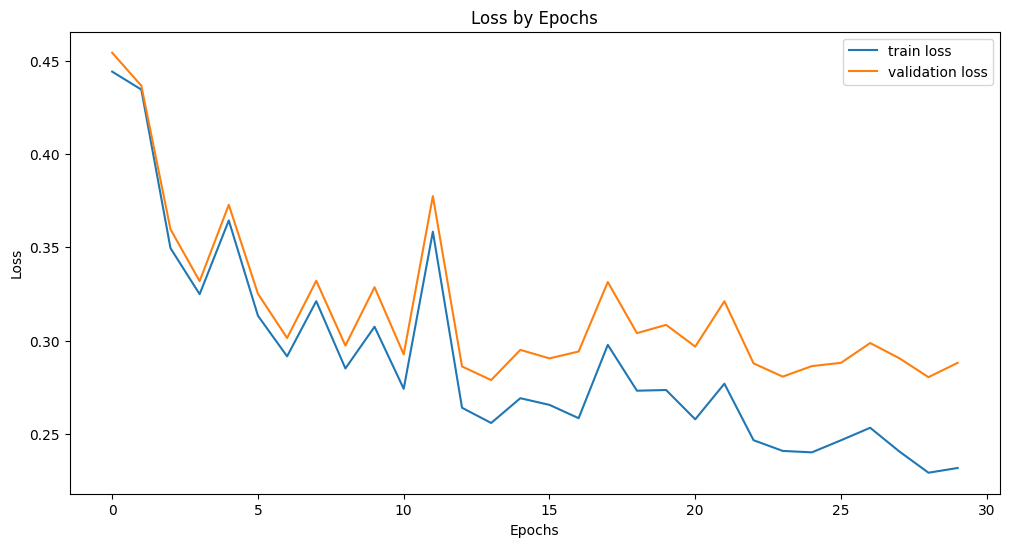

In [17]:
utils.plot_train_loss_hist(train_loss_hist, val_loss_hist)

In [13]:
acc = executor.test(model, test_dataset, evaluator, if_regression = True)
mae = executor.test(model, test_dataset, mean_absolute_error, if_regression = True)
mse = executor.test(model, test_dataset, mean_squared_error, if_regression = True)
print(f"Test accuracy: {acc:0.4f}")
print(f"Test Mean Absolute Error: {mae:0.4f}. Test Mean Squared Error: {mse:0.4f}")

Test accuracy: 0.9246
Test Mean Absolute Error: 0.2347. Test Mean Squared Error: 0.2806
